


**Step 1**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('/content/airbnb.csv')  # Replace with your path if needed

# Show structure
print("Dataset shape:", df.shape)
print("\nColumn Info:\n")
print(df.info())
print("\nFirst 5 Rows:\n")
print(df.head())


Dataset shape: (12805, 23)

Column Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12805 entries, 0 to 12804
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    12805 non-null  int64  
 1   id            12805 non-null  int64  
 2   name          12805 non-null  object 
 3   rating        12805 non-null  object 
 4   reviews       12805 non-null  object 
 5   host_name     12797 non-null  object 
 6   host_id       12805 non-null  float64
 7   address       12805 non-null  object 
 8   features      12805 non-null  object 
 9   amenities     12805 non-null  object 
 10  safety_rules  12805 non-null  object 
 11  hourse_rules  12805 non-null  object 
 12  img_links     12805 non-null  object 
 13  price         12805 non-null  int64  
 14  country       12805 non-null  object 
 15  bathrooms     12805 non-null  int64  
 16  beds          12805 non-null  int64  
 17  guests        12805 non-nul

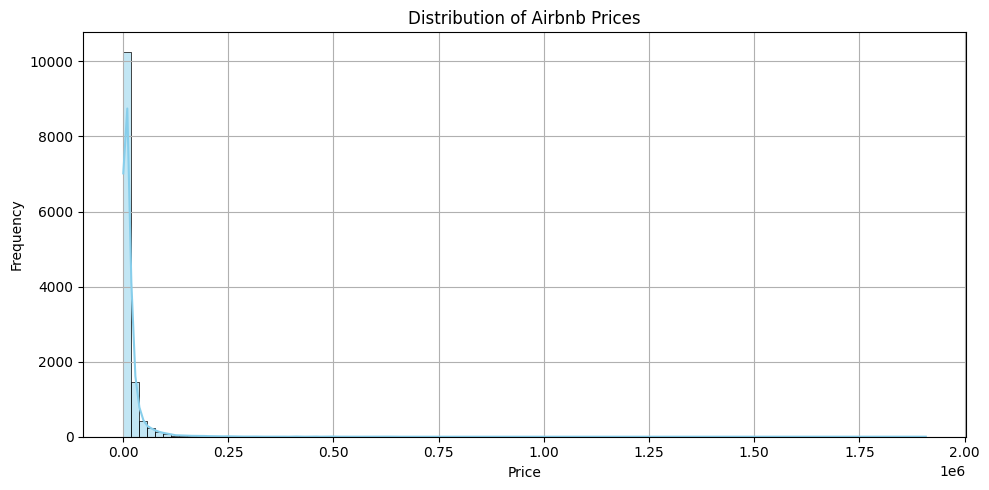

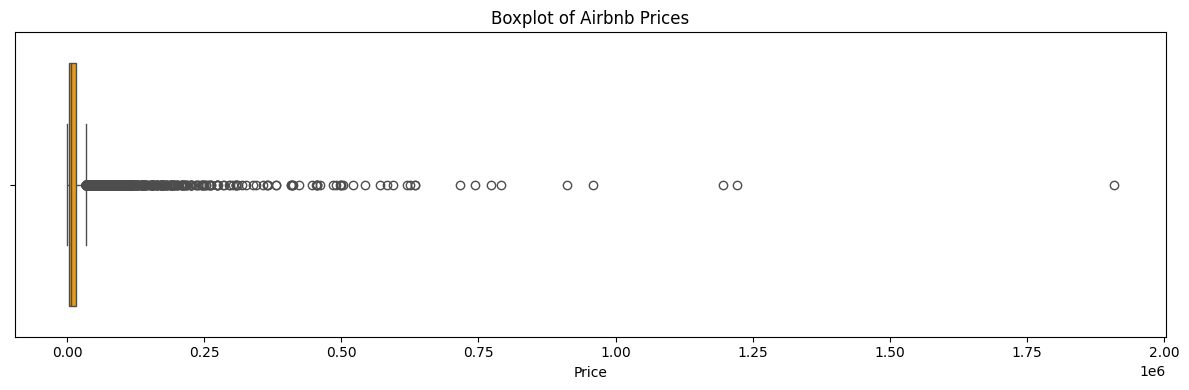

In [2]:
# Fix column names
df.columns = [col.lower().strip().replace(" ", "_") for col in df.columns]

# Convert rating and reviews to numeric
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["reviews"] = pd.to_numeric(df["reviews"], errors="coerce")

# Plot price distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["price"], bins=100, kde=True, color="skyblue")
plt.title("Distribution of Airbnb Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot boxplot to detect outliers
plt.figure(figsize=(12, 4))
sns.boxplot(x=df["price"], color="orange")
plt.title("Boxplot of Airbnb Prices")
plt.xlabel("Price")
plt.tight_layout()
plt.show()


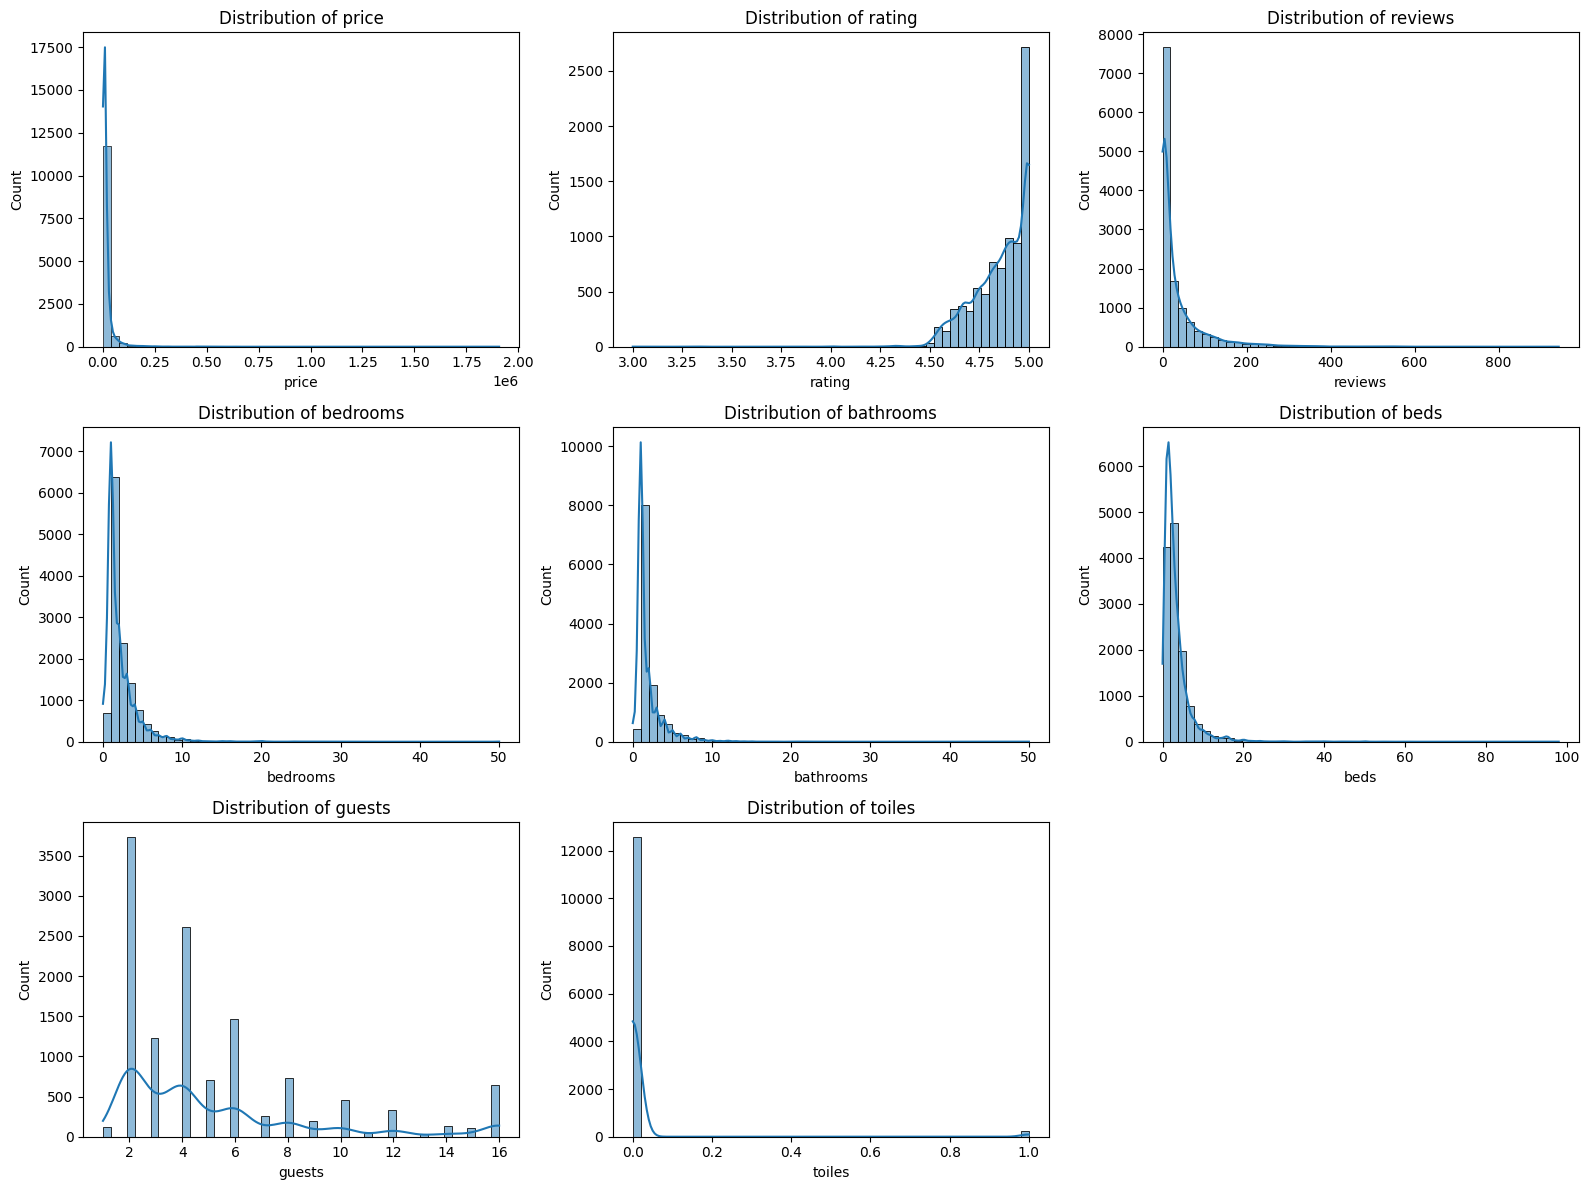

In [5]:
# Distribution of numerical features
numerical_features = ["price", "rating", "reviews", "bedrooms", "bathrooms", "beds", "guests", "toiles"]

plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.tight_layout()
plt.show()


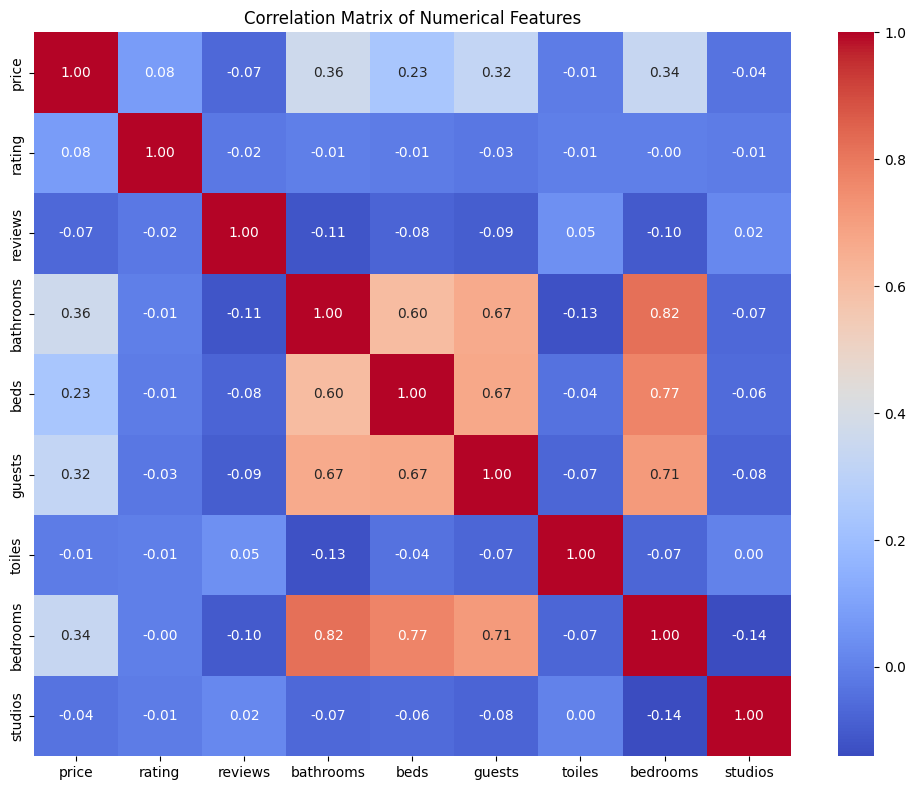

<ipython-input-3-c52a27cf36a5>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.index, y=top_countries.values, palette="Set2")


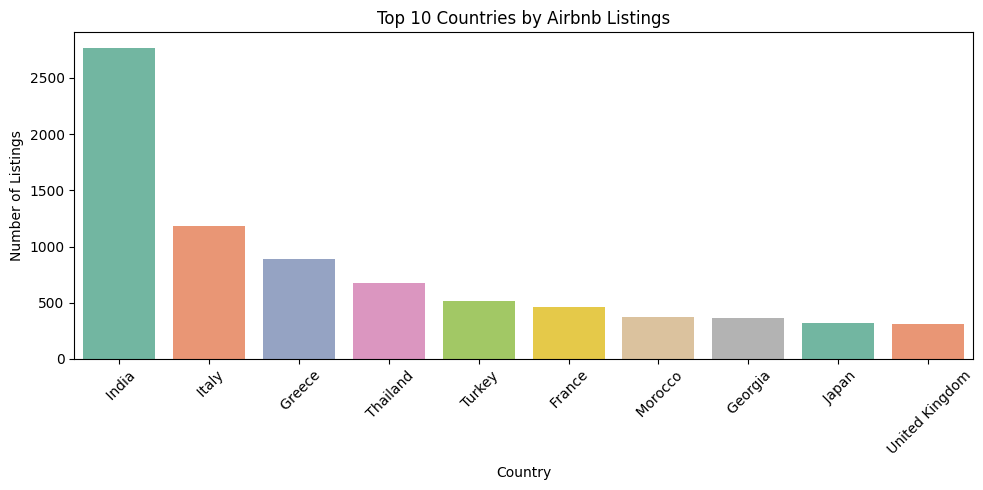

In [3]:
# Numerical correlation
num_cols = ["price", "rating", "reviews", "bathrooms", "beds", "guests", "toiles", "bedrooms", "studios"]
df_corr = df[num_cols].copy()
df_corr = df_corr.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

# Top 10 countries by listings
top_countries = df["country"].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.index, y=top_countries.values, palette="Set2")
plt.title("Top 10 Countries by Airbnb Listings")
plt.xlabel("Country")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


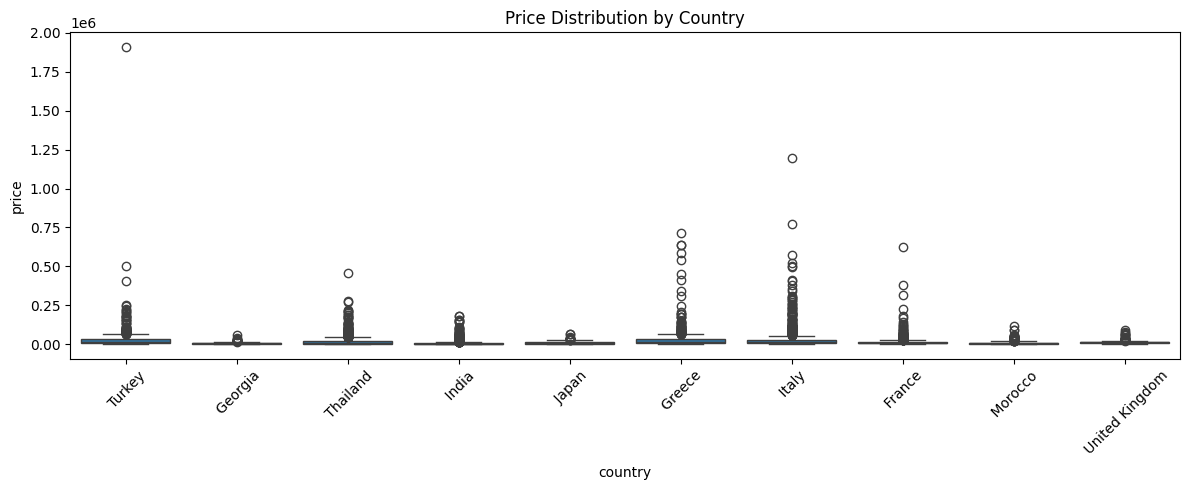

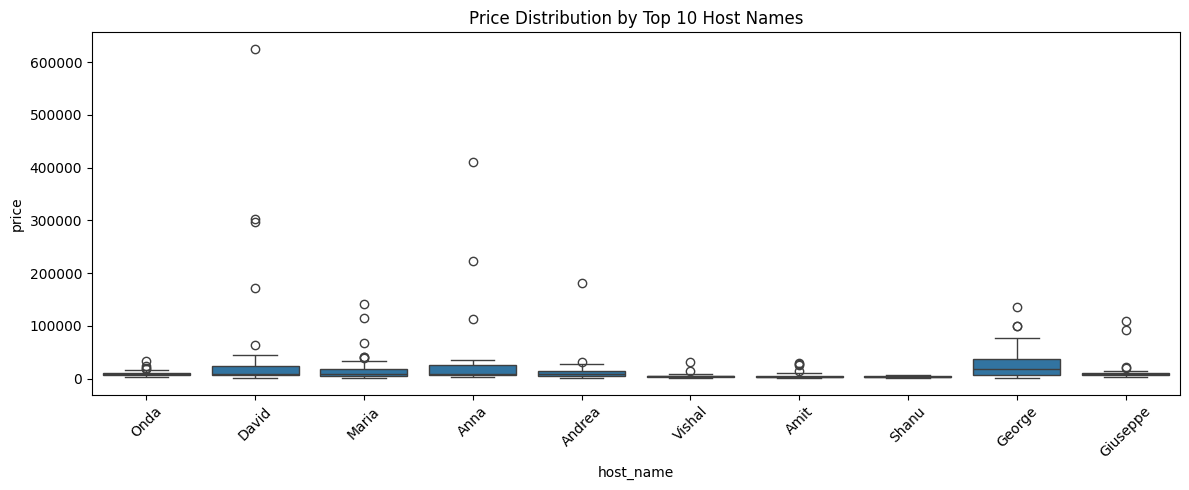

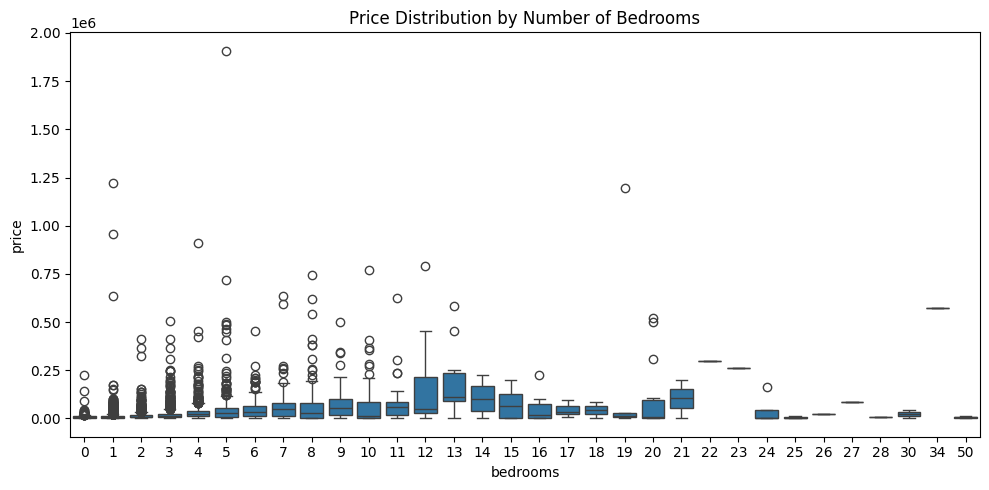

In [4]:
# Price vs Country
top_countries_names = df["country"].value_counts().head(10).index
plt.figure(figsize=(12, 5))
sns.boxplot(data=df[df["country"].isin(top_countries_names)], x="country", y="price")
plt.title("Price Distribution by Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Price vs Host Name
top_hosts = df["host_name"].value_counts().head(10).index
plt.figure(figsize=(12, 5))
sns.boxplot(data=df[df["host_name"].isin(top_hosts)], x="host_name", y="price")
plt.title("Price Distribution by Top 10 Host Names")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Price vs Bedrooms
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="bedrooms", y="price")
plt.title("Price Distribution by Number of Bedrooms")
plt.tight_layout()
plt.show()


**Step 2**

Pre-processing

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [7]:
# Make a fresh copy
data = df.copy()

In [8]:
# Rename typo
data.rename(columns={"toiles": "toilets"}, inplace=True)

# Display missing values
missing = data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values:\n", missing)

Missing values:
 rating       4238
checkout     2450
checkin       800
host_name       8
reviews         1
dtype: int64


In [9]:
# Drop irrelevant columns (check if they exist first)
drop_cols = [col for col in ["img_links", "safety_rules", "hourse_rules"] if col in data.columns]
data.drop(columns=drop_cols, inplace=True)

In [11]:
# Impute missing values in 'checkin', 'checkout', and 'host_name' using mode (safely)
for col in ["checkin", "checkout", "host_name"]:
    if col in data.columns:
        mode_value = data[col].mode()[0]
        data[col] = data[col].fillna(mode_value)

In [12]:
# Convert rating and reviews to numeric
data["rating"] = pd.to_numeric(data["rating"], errors="coerce")
data["reviews"] = pd.to_numeric(data["reviews"], errors="coerce")

In [13]:
# Drop rows with NaNs in essential numeric columns
essential_numeric = ["rating", "reviews"]
data.dropna(subset=essential_numeric, inplace=True)

In [14]:
# Outlier removal using IQR
Q1 = data["price"].quantile(0.25)
Q3 = data["price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data["price"] >= lower_bound) & (data["price"] <= upper_bound)]

In [15]:
# Extract features into usable columns
features_split = data["features"].str.extract(r'(?P<guests>\d+).*?(?P<bedrooms>\d+).*?(?P<beds>\d+).*?(?P<bathrooms>\d+)')
for col in features_split.columns:
    data[col] = pd.to_numeric(features_split[col], errors="coerce")
data.drop(columns=["features"], inplace=True)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Redefine all columns again
encoded_cols = ["country"]
numerical_cols = ["rating", "reviews", "bedrooms", "bathrooms", "beds", "guests", "toilets", "studios"]

# Create a clean copy
data_pro = data.copy()

# Step 1: Impute missing values with median (for numerical only)
for col in numerical_cols:
    if data_pro[col].isnull().any():
        data_pro[col] = SimpleImputer(strategy='median').fit_transform(data_pro[[col]])

# Step 2: Log transform skewed features
log_transform_cols = []
for col in numerical_cols:
    skewness = data_pro[col].skew()
    if skewness > 1:
        data_pro[col] = np.log1p(data_pro[col])
        log_transform_cols.append(col)

print("Log-transformed columns due to high skewness:", log_transform_cols)

# Step 3: ColumnTransformer with RobustScaler and OneHotEncoder
robust_preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False), encoded_cols),
    ("scale", RobustScaler(), numerical_cols)
])

# Final features and target
X_pro = data_pro[encoded_cols + numerical_cols]
y_pro = data_pro["price"]

# Apply transformation
X_transformed_pro = robust_preprocessor.fit_transform(X_pro)

Log-transformed columns due to high skewness: ['reviews', 'bedrooms', 'bathrooms', 'beds', 'guests', 'toilets', 'studios']


In [39]:
print("Shape:", X_transformed_pro.shape)

Shape: (7847, 141)


In [40]:
print("Sample (first 5 rows):\n", X_transformed_pro[:5])

Sample (first 5 rows):
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0

In [41]:
print("Any NaNs in X_transformed_pro?", np.isnan(X_transformed_pro).sum())

Any NaNs in X_transformed_pro? 0


**Step - 3: Model Creation**

In [27]:
!pip install tensorflow

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [29]:
def build_and_evaluate_ann(X, y, name):
    print(f"\n===== Training model on {name} =====")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(128, activation='relu', input_shape=(X.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    preds = model.predict(X_val).flatten()
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, preds)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

    return model, history, {"MAE": mae, "RMSE": rmse, "R2": r2}

In [42]:
model_pro, history_pro, metrics_pro = build_and_evaluate_ann(X_transformed_pro, y_pro, "Pre Processeded Data")


===== Training model on Pre Processeded Data =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 3735.82
RMSE: 5025.97
R² Score: 0.4279


**Step 4 :**

In [45]:
!pip install scikeras

Hyper Parameter Tuning

In [46]:
from tensorflow.keras.optimizers import Adam

# Define a deeper ANN model with different architecture
def build_tuned_ann(input_dim):
    model = Sequential([
        tf.keras.Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

# Train this tuned model
X_train, X_val, y_train, y_val = train_test_split(X_transformed_pro, y_pro, test_size=0.2, random_state=42)
model_tuned = build_tuned_ann(X_transformed_pro.shape[1])
history_tuned = model_tuned.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=100, batch_size=64, verbose=0,
                                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# Evaluate tuned model
y_pred_tuned = model_tuned.predict(X_val).flatten()
mae = mean_absolute_error(y_val, y_pred_tuned)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_tuned))
r2 = r2_score(y_val, y_pred_tuned)

print("Tuned ANN Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Tuned ANN Performance:
MAE: 3744.77
RMSE: 5021.75
R² Score: 0.4289


More Hyper Parameter Tuning

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Deep, regularized ANN architecture with learning rate scheduler
def build_advanced_ann(input_dim):
    model = Sequential([
        tf.keras.Input(shape=(input_dim,)),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse', metrics=['mae'])
    return model

# Split data again
X_train, X_val, y_train, y_val = train_test_split(X_transformed_pro, y_pro, test_size=0.2, random_state=42)

# Build and train model
model_deep = build_advanced_ann(X_transformed_pro.shape[1])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
]

history_deep = model_deep.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=0
)

# Evaluate
y_pred_deep = model_deep.predict(X_val).flatten()
mae = mean_absolute_error(y_val, y_pred_deep)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_deep))
r2 = r2_score(y_val, y_pred_deep)

print("Deep ANN Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 34: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 39: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Deep ANN Performance:
MAE: 3730.03
RMSE: 5063.66
R² Score: 0.4193


Cross Validation

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define advanced ANN builder
def build_advanced_ann(input_dim):
    model = Sequential([
        tf.keras.Input(shape=(input_dim,)),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse', metrics=['mae'])
    return model

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_transformed_pro)):
    print(f"\nFold {fold+1}")

    X_train, X_val = X_transformed_pro[train_idx], X_transformed_pro[val_idx]
    y_train, y_val = y_pro.iloc[train_idx], y_pro.iloc[val_idx]

    model = build_advanced_ann(X_transformed_pro.shape[1])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        batch_size=64,
        verbose=0,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=0)
        ]
    )

    y_pred = model.predict(X_val).flatten()
    mae_scores.append(mean_absolute_error(y_val, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    r2_scores.append(r2_score(y_val, y_pred))

# Report average CV results
print("\nCross-Validation Results (5-Fold):")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average R² Score: {np.mean(r2_scores):.4f}")



Fold 1
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Cross-Validation Results (5-Fold):
Average MAE: 3715.96
Average RMSE: 5102.25
Average R² Score: 0.4177


Combine Models

In [50]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [54]:
# Redefine encoded and numerical columns
encoded_cols = ["country"]
numerical_cols = ["rating", "reviews", "bedrooms", "bathrooms", "beds", "guests", "studios", "toilets"]

# Prepare input from data_pro instead of df
X_ens = data_pro[encoded_cols + numerical_cols]
X_ens = pd.get_dummies(X_ens)  # One-hot encode country
y_ens = data_pro["price"]


In [55]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_ens, y_ens, test_size=0.2, random_state=42)

In [56]:
# Model 1: Random Forest
rf = RandomForestRegressor(n_estimators=150, max_depth=12, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [57]:
# Model 2: Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [58]:
# Model 3: HistGradientBoosting (optimized for tabular data)
hgb = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.1, max_depth=6, random_state=42)
hgb.fit(X_train, y_train)
y_pred_hgb = hgb.predict(X_test)

In [60]:
# Model 4: Stacked Regressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

stack = StackingRegressor(
    estimators=[
        ("rf", rf),
        ("gb", gb),
        ("hgb", hgb),
        ("nn", make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, solver='adam', random_state=42)))
    ],
    final_estimator=Ridge(alpha=1.0)
)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

In [61]:
# Evaluate all models
def evaluate(name, y_true, y_pred):
    print(f"\n {name} Results:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")

evaluate("Random Forest", y_test, y_pred_rf)
evaluate("Gradient Boosting", y_test, y_pred_gb)
evaluate("HistGradientBoosting", y_test, y_pred_hgb)
evaluate("Stacked Regressor (Ensemble)", y_test, y_pred_stack)


 Random Forest Results:
MAE: 3830.56
RMSE: 5145.10
R² Score: 0.4005

 Gradient Boosting Results:
MAE: 3713.65
RMSE: 5077.34
R² Score: 0.4161

 HistGradientBoosting Results:
MAE: 3675.56
RMSE: 4970.70
R² Score: 0.4404

 Stacked Regressor (Ensemble) Results:
MAE: 3594.24
RMSE: 4875.47
R² Score: 0.4617


ANN + Random Forest

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_transformed_pro, y_pro, test_size=0.2, random_state=42)

# Build best ANN model again (same architecture used in cross-validation)
def build_advanced_ann(input_dim):
    model = Sequential([
        tf.keras.Input(shape=(input_dim,)),
        Dense(512, activation='relu'), BatchNormalization(), Dropout(0.5),
        Dense(256, activation='relu'), BatchNormalization(), Dropout(0.4),
        Dense(128, activation='relu'), BatchNormalization(), Dropout(0.3),
        Dense(64, activation='relu'), Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse', metrics=['mae'])
    return model

# Train ANN
model_deep = build_advanced_ann(X_train.shape[1])
model_deep.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=64,
    verbose=0,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
    ]
)







Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 35: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 40: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.


In [75]:
# Train Random Forest on the same data
X_rf = data_pro[["country", "rating", "reviews", "bedrooms", "bathrooms", "beds", "guests", "studios", "toilets"]]
X_rf = pd.get_dummies(X_rf)
X_train_rf, X_test_rf = train_test_split(X_rf, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=150, max_depth=12, random_state=42)
rf_model.fit(X_train_rf, y_train)


RandomForestRegressor(max_depth=12, n_estimators=150, random_state=42)

In [76]:
# Predictions
y_pred_ann = model_deep.predict(X_test).flatten()
y_pred_rf = rf_model.predict(X_test_rf)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [79]:
from sklearn.linear_model import LinearRegression
# Combine predictions using stacked generalization
stacked_preds = np.vstack((y_pred_ann, y_pred_rf)).T
meta_model = LinearRegression()
meta_model.fit(stacked_preds, y_test)
y_pred_meta = meta_model.predict(stacked_preds)

# Evaluate
mae_meta = mean_absolute_error(y_test, y_pred_meta)
rmse_meta = np.sqrt(mean_squared_error(y_test, y_pred_meta))
r2_meta = r2_score(y_test, y_pred_meta)

print("Final Combined Model (ANN + RF via Meta Learner):")
print(f"MAE: {mae_meta:.2f}")
print(f"RMSE: {rmse_meta:.2f}")
print(f"R² Score: {r2_meta:.4f}")


Final Combined Model (ANN + RF via Meta Learner):
MAE: 3609.82
RMSE: 4864.42
R² Score: 0.4641


ANN + Gradient Boosting

In [80]:
from sklearn.linear_model import LinearRegression
# Combine predictions using stacked generalization
stacked_preds = np.vstack((y_pred_ann, y_pred_gb)).T
meta_model = LinearRegression()
meta_model.fit(stacked_preds, y_test)
y_pred_meta = meta_model.predict(stacked_preds)

# Evaluate
mae_meta = mean_absolute_error(y_test, y_pred_meta)
rmse_meta = np.sqrt(mean_squared_error(y_test, y_pred_meta))
r2_meta = r2_score(y_test, y_pred_meta)

print("Final Combined Model (ANN + GB via Meta Learner):")
print(f"MAE: {mae_meta:.2f}")
print(f"RMSE: {rmse_meta:.2f}")
print(f"R² Score: {r2_meta:.4f}")

Final Combined Model (ANN + GB via Meta Learner):
MAE: 3611.14
RMSE: 4875.54
R² Score: 0.4616


ANN + HistGradientBoosting

In [84]:
from sklearn.linear_model import LinearRegression
# Combine predictions using stacked generalization
stacked_preds = np.vstack((y_pred_ann, y_pred_hgb)).T
meta_model = LinearRegression()
meta_model.fit(stacked_preds, y_test)
y_pred_meta = meta_model.predict(stacked_preds)

# Evaluate
mae_meta = mean_absolute_error(y_test, y_pred_meta)
rmse_meta = np.sqrt(mean_squared_error(y_test, y_pred_meta))
r2_meta = r2_score(y_test, y_pred_meta)

print("Final Combined Model (ANN + HGB via Meta Learner):")
print(f"MAE: {mae_meta:.2f}")
print(f"RMSE: {rmse_meta:.2f}")
print(f"R² Score: {r2_meta:.4f}")

Final Combined Model (ANN + HGB via Meta Learner):
MAE: 3583.34
RMSE: 4839.21
R² Score: 0.4696


ANN + HGB + RF + GB using Linear Regression

In [85]:
from sklearn.linear_model import LinearRegression
# Combine predictions using stacked generalization
stacked_preds = np.vstack((y_pred_ann, y_pred_hgb, y_pred_rf, y_pred_gb)).T
meta_model = LinearRegression()
meta_model.fit(stacked_preds, y_test)
y_pred_meta = meta_model.predict(stacked_preds)

# Evaluate
mae_meta = mean_absolute_error(y_test, y_pred_meta)
rmse_meta = np.sqrt(mean_squared_error(y_test, y_pred_meta))
r2_meta = r2_score(y_test, y_pred_meta)

print("Final Combined Model (ANN + HGB + RF + GB via Meta Learner):")
print(f"MAE: {mae_meta:.2f}")
print(f"RMSE: {rmse_meta:.2f}")
print(f"R² Score: {r2_meta:.4f}")

Final Combined Model (ANN + HGB + RF + GB via Meta Learner):
MAE: 3576.58
RMSE: 4837.53
R² Score: 0.4700


In [86]:
# Combine predictions using stacked generalization
stacked_preds = np.vstack((y_pred_ann, y_pred_hgb, y_pred_rf, y_pred_gb)).T

ANN + HGB + RF + GB using RidgeCV

In [88]:
from sklearn.linear_model import RidgeCV

meta_model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
meta_model.fit(stacked_preds, y_test)
y_pred_meta = meta_model.predict(stacked_preds)
# Evaluate
mae_meta = mean_absolute_error(y_test, y_pred_meta)
rmse_meta = np.sqrt(mean_squared_error(y_test, y_pred_meta))
r2_meta = r2_score(y_test, y_pred_meta)

print("Final Combined Model (ANN + HGB + RF + GB via Meta Learner):")
print(f"MAE: {mae_meta:.2f}")
print(f"RMSE: {rmse_meta:.2f}")
print(f"R² Score: {r2_meta:.4f}")

Final Combined Model (ANN + HGB + RF + GB via Meta Learner):
MAE: 3576.59
RMSE: 4837.53
R² Score: 0.4700


ANN + HGB + RF + GB using Neural Network as Meta-Learner

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

meta_nn = Sequential([
    Dense(8, activation='relu', input_shape=(stacked_preds.shape[1],)),
    Dense(1)
])
meta_nn.compile(optimizer=Adam(0.01), loss='mse')
meta_nn.fit(stacked_preds, y_test, epochs=100, batch_size=16, verbose=0)
y_pred_meta = meta_nn.predict(stacked_preds).flatten()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [90]:
# Evaluate
mae_meta = mean_absolute_error(y_test, y_pred_meta)
rmse_meta = np.sqrt(mean_squared_error(y_test, y_pred_meta))
r2_meta = r2_score(y_test, y_pred_meta)

print("Final Combined Model (ANN + HGB + RF + GB via Meta Learner):")
print(f"MAE: {mae_meta:.2f}")
print(f"RMSE: {rmse_meta:.2f}")
print(f"R² Score: {r2_meta:.4f}")

Final Combined Model (ANN + HGB + RF + GB via Meta Learner):
MAE: 3527.32
RMSE: 4850.01
R² Score: 0.4673


ANN + HGB + RF + GB using Optimized Weighted Average

In [91]:
from scipy.optimize import minimize

def weighted_mse(weights):
    ensemble_pred = np.average(stacked_preds, axis=1, weights=weights)
    return mean_squared_error(y_test, ensemble_pred)

# Initial weights = equal
init_weights = np.ones(stacked_preds.shape[1]) / stacked_preds.shape[1]

# Constraints: weights sum to 1
cons = {'type': 'eq', 'fun': lambda w: 1 - np.sum(w)}
bounds = [(0, 1)] * stacked_preds.shape[1]

res = minimize(weighted_mse, init_weights, bounds=bounds, constraints=cons)
best_weights = res.x
y_pred_meta = np.average(stacked_preds, axis=1, weights=best_weights)


In [92]:
# Evaluate
mae_meta = mean_absolute_error(y_test, y_pred_meta)
rmse_meta = np.sqrt(mean_squared_error(y_test, y_pred_meta))
r2_meta = r2_score(y_test, y_pred_meta)

print("Final Combined Model (ANN + HGB + RF + GB via Meta Learner):")
print(f"MAE: {mae_meta:.2f}")
print(f"RMSE: {rmse_meta:.2f}")
print(f"R² Score: {r2_meta:.4f}")

Final Combined Model (ANN + HGB + RF + GB via Meta Learner):
MAE: 3602.81
RMSE: 4881.68
R² Score: 0.4603
